In [1]:
import xarray as xr
import numpy as np
import xgcm
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 16

from bbl_utils import *

import warnings
warnings.filterwarnings('ignore', '.*.')

div_cmap = plt.get_cmap('RdBu_r')
div_cmap.set_bad(color=(0.8,0.8,0.8))

cmap = plt.get_cmap('viridis')
cmap.set_bad(color=(0.8,0.8,0.8))

In [2]:
iters=[72000, 1440000, 2952000, 1440000+2880000]
iters=np.arange(2880000+72000, 1440000+2880000, 72000)

### Physical parameters

In [3]:
Γ = 0.0008613659531090722
θ = 1.53E-3
f = 0.53e-4

### Load dataset

In [4]:
kappa_list = [1, 4, 8]
ds_list = []
coords_list = []

for kappa in kappa_list:
    data_dir_2D = f"../../MITgcm/experiments/rotated_BBTRE_2D_kappa-{kappa}x/run/"
    ds_2D = open_mdsdataset(data_dir_2D,iters=iters,ignore_unknown_vars=True,prefix=["standardDiag", "budgetDiag", "tracer01Diag", "tracer02Diag"])
    ds_2D, coords_2D, grid_2D = pre_process(ds_2D)
    ds_2D, coords_2D = add_cartesian_coordinates(ds_2D, coords_2D, θ)
    ds_2D = add_background_temp(ds_2D, Γ)
    ds_2D, coords_2D = add_hab_coordinates(ds_2D, coords_2D)
    ds_2D = add_Nsq(ds_2D, Γ)
    
    ds_list.append(ds_2D)
    coords_list.append(coords_2D)

In [5]:
ds = ds_list[0]
coords = coords_list[0]

In [6]:
ds['TRAC01'] = ds['TRAC01'].where(coords['hFacC'] != 0.).compute()
ds['TRAC02'] = ds['TRAC02'].where(coords['hFacC'] != 0.).compute()

In [25]:
x1 = 3.e4; x2 = x1; δx = 1.e4;
z1 = 100.
z2 = 900.
δz = 40.;

H = coords['Depth'].max().values.copy().astype('>f8')
seafloor = H - coords['Depth']

C1 = np.exp(- ((ds['XC'] - x2)/δx)**2 - ((ds['Z'] - seafloor.sel(XC=x2, method='nearest') - z2)/δz)**2)
C2 = np.exp(- ((ds['XC'] - x1)/δx)**2 - ((ds['Z'] - seafloor.sel(XC=x1, method='nearest') - z1)/δz)**2)

C1 = C1.where(coords['Z'] - seafloor >= 0)
C2 = C2.where(coords['Z'] - seafloor >= 0)

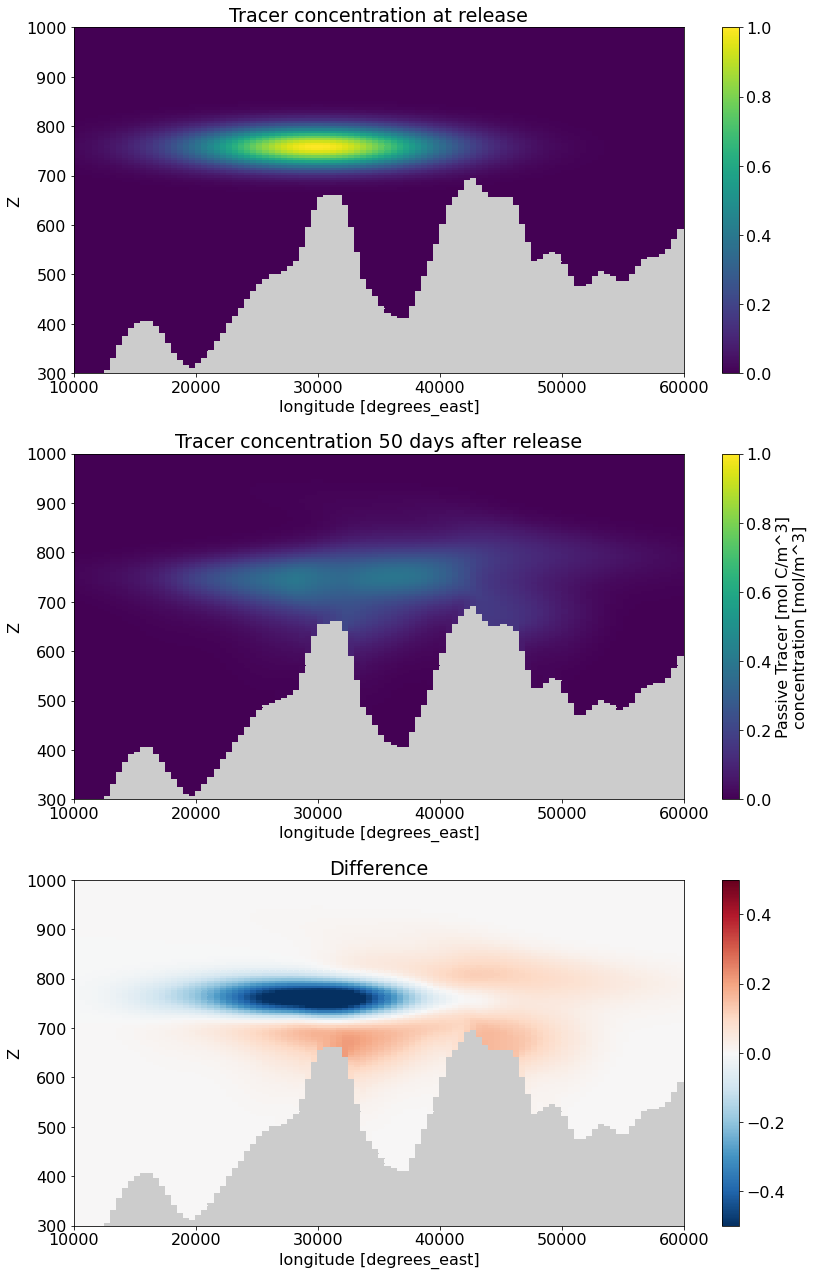

In [124]:
plt.figure(figsize=(12,18))

plt.subplot(3,1,1)
q = (C1).plot(y = 'Z')
plt.xlim([10000, 60000])
plt.ylim([300, 1000])
q.set_clim([0, 1])
plt.title("Tracer concentration at release")

plt.subplot(3,1,2)
q = (ds['TRAC02'].isel(time=0)).plot(y = 'Z')
plt.xlim([10000, 60000])
plt.ylim([300, 1000])
q.set_clim([0, 1])
plt.title("Tracer concentration 50 days after release")

plt.subplot(3,1,3)
q = (ds['TRAC02'].isel(time=0) - C1).plot(y = 'Z')
plt.xlim([10000, 60000])
plt.ylim([300, 1000])
q.set_clim([-0.5, 0.5])
plt.title("Difference")

plt.tight_layout()
plt.savefig("../../figures/BBTRE/initial_tracer_spreading.png", dpi=150, bbox_inches='tight')

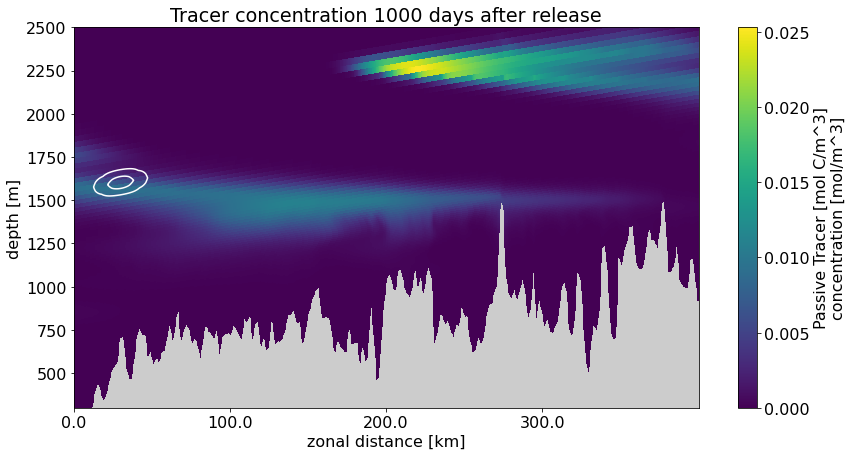

In [41]:
plt.figure(figsize=(14,7))
plt.subplot(1,1,1, facecolor=(0.8, 0.8, 0.8))
ds['TRAC01'] = ds['TRAC01'].where(ds['TRAC01'] != 0.)
ds['TRAC01'].isel(time=-1).plot(y='Zr', x='Xr')
plt.contour(ds['TRAC01'].Xr.values, ds['TRAC01'].Zr.values, C1.values.squeeze(), colors='w', levels=[0.05, 0.5])
plt.ylim([300, 2500])
plt.xticks(np.arange(0,4,1)*1.e5, np.arange(0,4,1)*1.e2)
plt.xlabel("zonal distance [km]")
plt.ylabel("depth [m]")
plt.title("Tracer concentration 1000 days after release")
plt.savefig("../../figures/BBTRE/interior_tracer_spread.png", dpi=150, bbox_inches='tight')

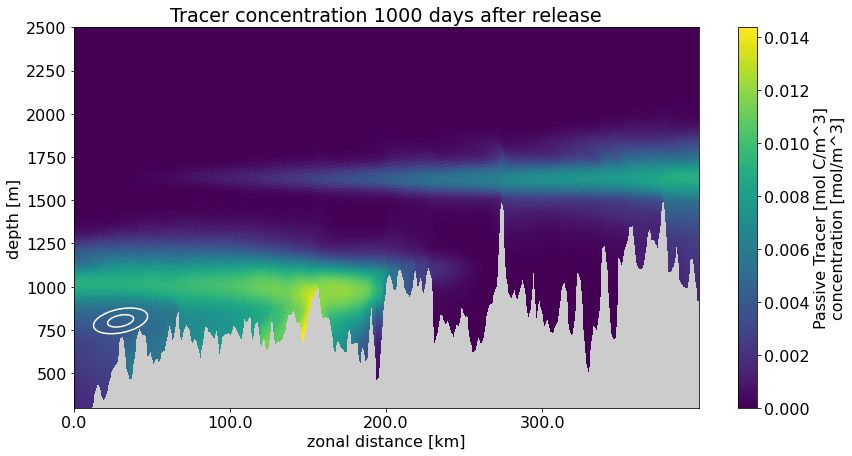

In [42]:
plt.figure(figsize=(14,7))
plt.subplot(1,1,1, facecolor=(0.8, 0.8, 0.8))
ds['TRAC02'] = ds['TRAC02'].where(ds['TRAC02'] != 0.)
ds['TRAC02'].isel(time=-1).plot(y='Zr', x='Xr')
plt.contour(ds['TRAC02'].Xr.values, ds['TRAC02'].Zr.values, C2.values.squeeze(), colors='w', levels=[0.05, 0.5])
plt.ylim([300, 2500])
plt.xticks(np.arange(0,4,1)*1.e5, np.arange(0,4,1)*1.e2)
plt.xlabel("zonal distance [km]")
plt.ylabel("depth [m]")
plt.title("Tracer concentration 1000 days after release")
plt.savefig("../../figures/BBTRE/bottom_tracer_spread.png", dpi=150, bbox_inches='tight')

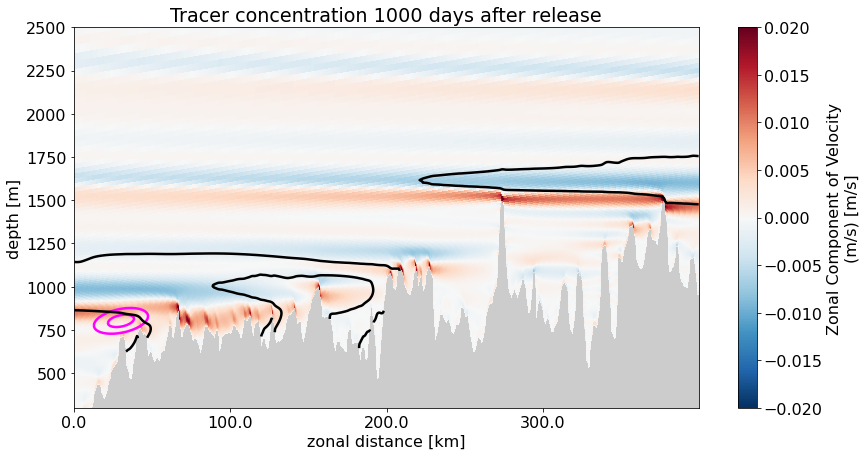

In [76]:
plt.figure(figsize=(14,7))
plt.subplot(1,1,1, facecolor=(0.8, 0.8, 0.8))
ds['UVEL'] = ds['UVEL'].where(ds['UVEL'] != 0.)
q = ds['UVEL'].isel(time=-1).plot(x='Xr_U', y='Zr_U')
q.set_clim([-2.e-2,2.e-2])
plt.contour(ds['TRAC02'].Xr.values, ds['TRAC02'].Zr.values, C2.values.squeeze(), colors='magenta', linewidths = 2.5, levels=[0.05, 0.5])
plt.contour(ds['TRAC02'].Xr.values, ds['TRAC02'].Zr.values, np.transpose(ds['TRAC02'].isel(time=-1).squeeze().values), colors='k', linewidths = 2.5, levels=[0.005, 0.01])
plt.ylim([300, 2500])
plt.xticks(np.arange(0,4,1)*1.e5, np.arange(0,4,1)*1.e2)
plt.xlabel("zonal distance [km]")
plt.ylabel("depth [m]")
plt.title("Tracer concentration 1000 days after release")
plt.savefig("../../figures/BBTRE/bottom_tracer_spread_u_overlay.png", dpi=150, bbox_inches='tight')

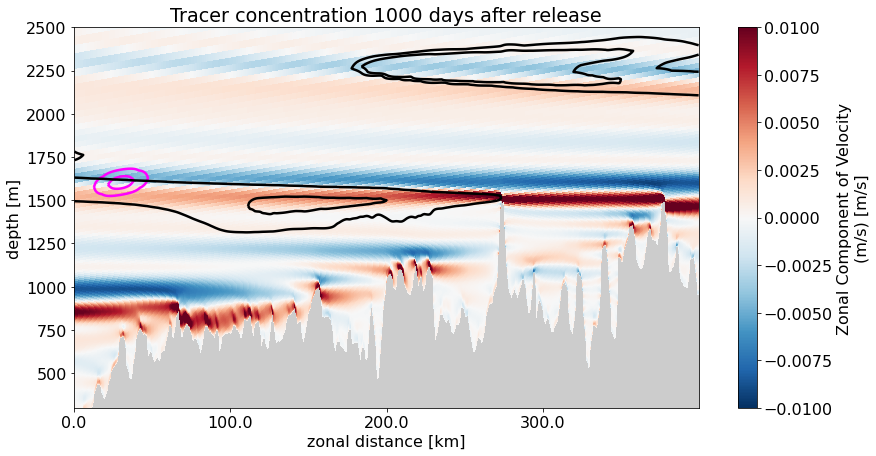

In [77]:
plt.figure(figsize=(14,7))
plt.subplot(1,1,1, facecolor=(0.8, 0.8, 0.8))
ds['UVEL'] = ds['UVEL'].where(ds['UVEL'] != 0.)
q = ds['UVEL'].isel(time=-1).plot(x='Xr_U', y='Zr_U')
q.set_clim([-1.e-2,1.e-2])
plt.contour(ds['TRAC01'].Xr.values, ds['TRAC01'].Zr.values, C1.values.squeeze(), colors='magenta', linewidths = 2.5, levels=[0.05, 0.5])
plt.contour(ds['TRAC01'].Xr.values, ds['TRAC01'].Zr.values, np.transpose(ds['TRAC01'].isel(time=-1).squeeze().values), colors='k', linewidths = 2.5, levels=[0.005, 0.01])
plt.ylim([300, 2500])
plt.xticks(np.arange(0,4,1)*1.e5, np.arange(0,4,1)*1.e2)
plt.xlabel("zonal distance [km]")
plt.ylabel("depth [m]")
plt.title("Tracer concentration 1000 days after release")
plt.savefig("../../figures/BBTRE/interior_tracer_spread_u_overlay.png", dpi=150, bbox_inches='tight')

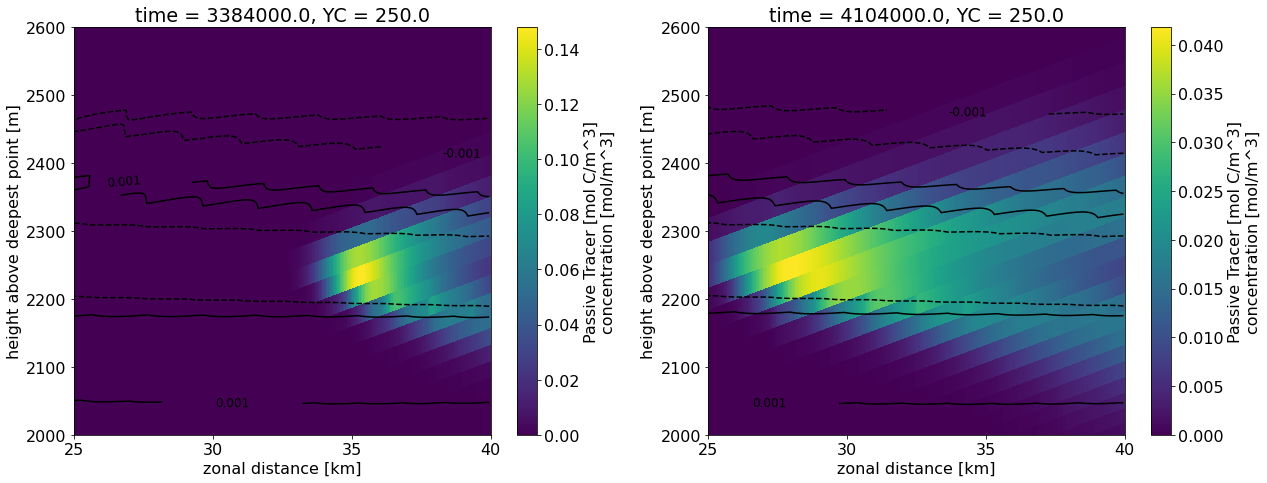

In [102]:
plt.figure(figsize=(18,7))

plt.subplot(1,2,1)
ds['TRAC01'].isel(time=-6).plot(x='Xr', y='Zr')
CS = ds['UVEL'].isel(time=-7, YC=0).plot.contour(x='Xr_U', y='Zr_U', colors = "k", levels=np.array([-0.5e-3, 0.5e-3]))
plt.clabel(CS, inline=1, fontsize=12)
plt.ylim([2000, 2600])
plt.xlim([250000, 400000])
plt.xticks([25e4, 30e4, 35e4, 40e4], [25, 30, 35, 40])
plt.ylabel("height above deepest point [m]")
plt.xlabel("zonal distance [km]")

plt.subplot(1,2,2)
ds['TRAC01'].isel(time=-1).plot(x='Xr', y='Zr')
CS = ds['UVEL'].isel(time=-2, YC=0).plot.contour(x='Xr_U', y='Zr_U', colors = "k", levels=np.array([-0.5e-3, 0.5e-3]))
plt.clabel(CS, inline=1, fontsize=12)
plt.ylim([2000, 2600])
plt.xlim([250000, 400000])
plt.xticks([25e4, 30e4, 35e4, 40e4], [25, 30, 35, 40])
plt.ylabel("height above deepest point [m]")
plt.xlabel("zonal distance [km]")

plt.tight_layout()

# Stratification plots

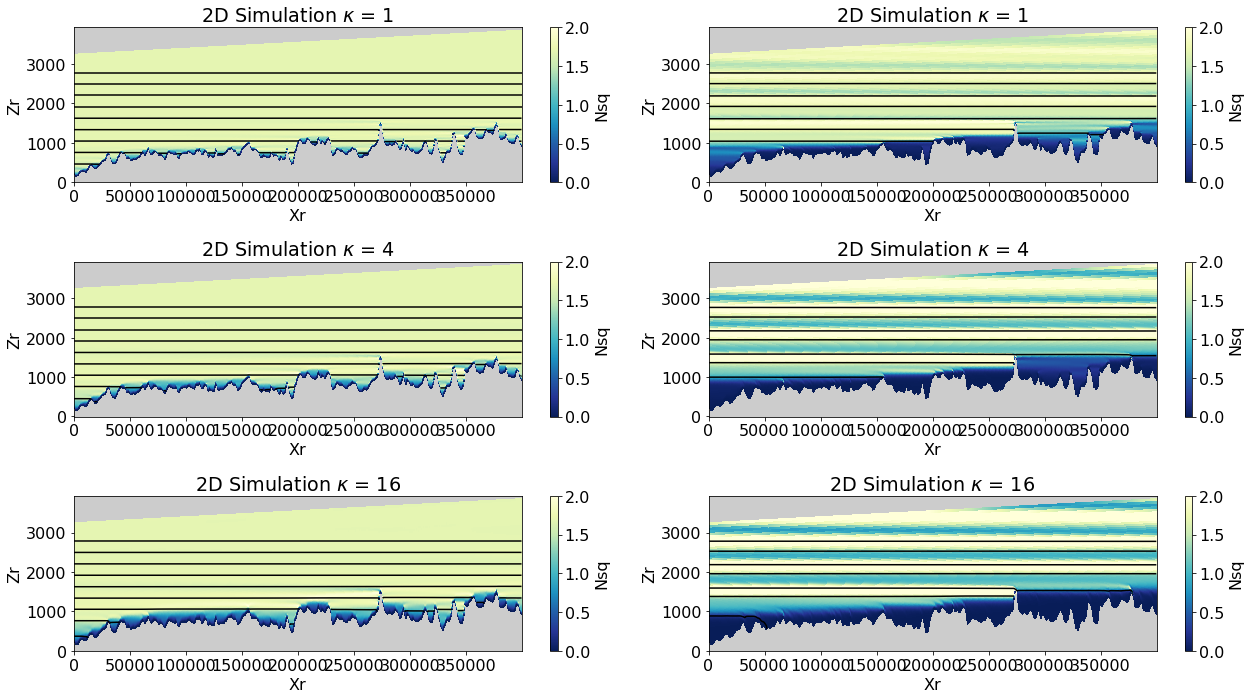

In [17]:
plt.figure(figsize=(18,10))


for i, kappa in enumerate(kappa_list):
    
    plt.subplot(len(kappa_list),2,i*2+1, facecolor=(.8, .8, .8))

    ti = 0
    ds = ds_list[i]
    coords = coords_list[i]

    q = (ds['Nsq']*1e6).isel(time=ti).mean(dim='YC').plot(x='Xr_W', y='Zr_W', cmap='YlGnBu_r')
    q.set_clim([0., 2.0])
    ds['THETA_BG'].isel(time=ti).sel(YC=3e4, method='nearest').plot.contour(x='Xr', y='Zr', colors='black', levels=np.arange(0.4, 2.5, 0.25))
    #plt.ylim([0,2500])
    plt.title(fr"2D Simulation $\kappa$ = {kappa}")
    
    plt.subplot(len(kappa_list),2,i*2+2, facecolor=(.8, .8, .8))

    ti = -1
    ds = ds_list[i]
    coords = coords_list[i]

    q = (ds['Nsq']*1e6).isel(time=ti).mean(dim='YC').plot(x='Xr_W', y='Zr_W', cmap='YlGnBu_r')
    q.set_clim([0., 2.0])
    ds['THETA_BG'].isel(time=ti).sel(YC=3e4, method='nearest').plot.contour(x='Xr', y='Zr', colors='black', levels=np.arange(0.4, 2.5, 0.25))
    #plt.ylim([0,2500])
    plt.title(fr"2D Simulation $\kappa$ = {kappa}")

    
plt.tight_layout()

plt.savefig("../../figures/stratification_scaling_full.png", dpi=150, bbox_inches="tight")

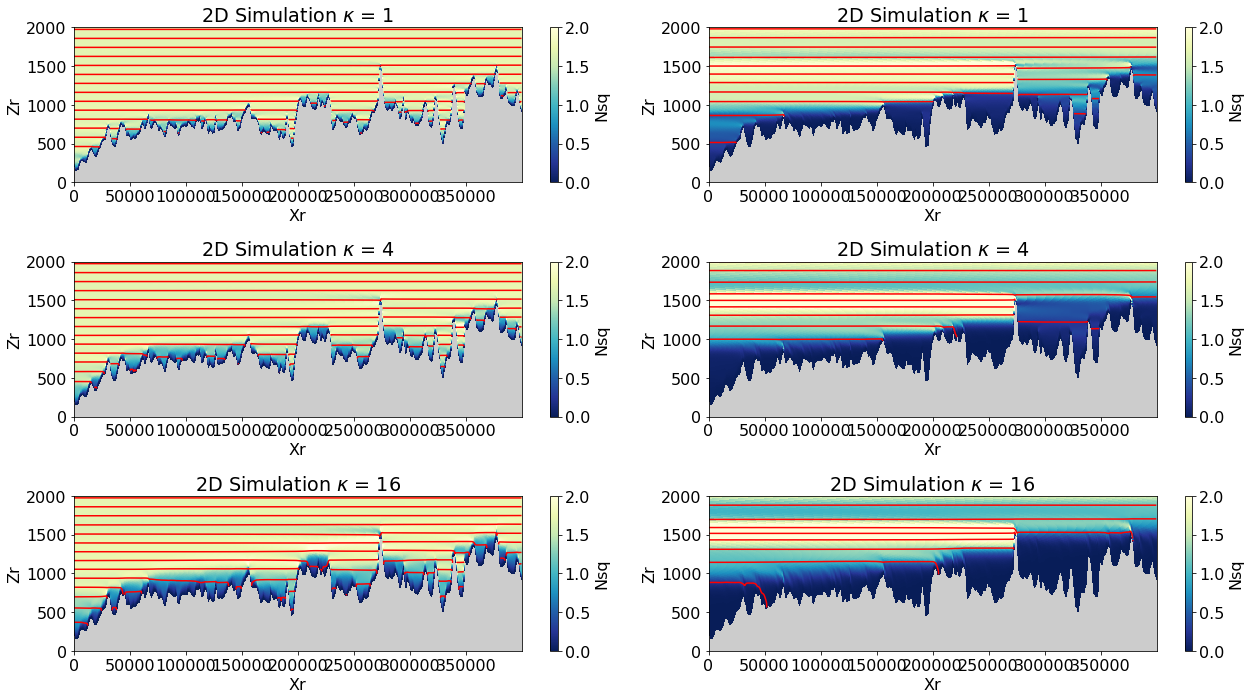

In [18]:
plt.figure(figsize=(18,10))


for i, kappa in enumerate(kappa_list):
    
    plt.subplot(len(kappa_list),2,i*2+1, facecolor=(.8, .8, .8))

    ti = 0
    ds = ds_list[i]
    coords = coords_list[i]

    q = (ds['Nsq']*1e6).isel(time=ti).mean(dim='YC').plot(x='Xr_W', y='Zr_W', cmap='YlGnBu_r')
    q.set_clim([0., 2.0])
    ds['THETA_BG'].isel(time=ti).sel(YC=3e4, method='nearest').plot.contour(x='Xr', y='Zr', colors='r', levels=np.arange(0.4, 2.5, 0.1))
    plt.ylim([0,2000])
    plt.title(fr"2D Simulation $\kappa$ = {kappa}")
    
    plt.subplot(len(kappa_list),2,i*2+2, facecolor=(.8, .8, .8))

    ti = -1
    ds = ds_list[i]
    coords = coords_list[i]

    q = (ds['Nsq']*1e6).isel(time=ti).mean(dim='YC').plot(x='Xr_W', y='Zr_W', cmap='YlGnBu_r')
    q.set_clim([0., 2.0])
    ds['THETA_BG'].isel(time=ti).sel(YC=3e4, method='nearest').plot.contour(x='Xr', y='Zr', colors='r', levels=np.arange(0.4, 2.5, 0.1))
    plt.ylim([0,2000])
    plt.title(fr"2D Simulation $\kappa$ = {kappa}")

    
plt.tight_layout()

plt.savefig("../../figures/stratification_scaling.png", dpi=150, bbox_inches="tight")

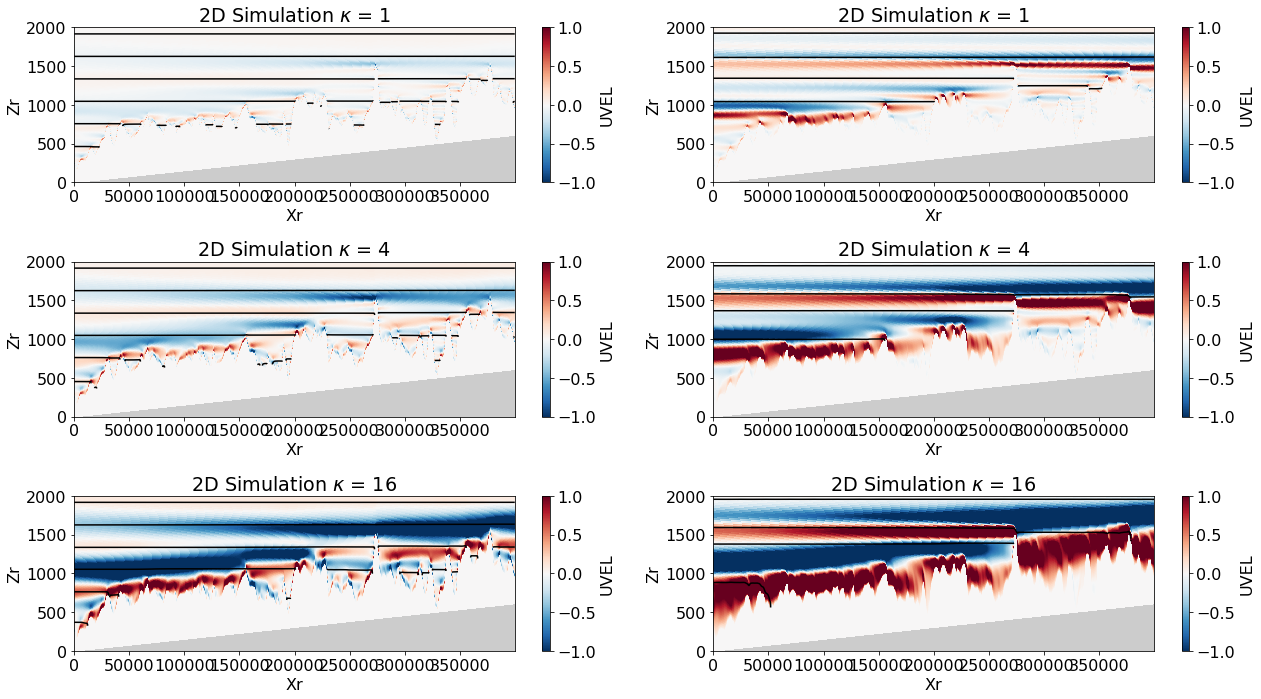

In [19]:
plt.figure(figsize=(18,10))


for i, kappa in enumerate(kappa_list):
    
    plt.subplot(len(kappa_list),2,i*2+1, facecolor=(.8, .8, .8))

    ti = 0
    ds = ds_list[i]
    coords = coords_list[i]

    q = (ds['UVEL']*1e2).isel(time=ti).mean(dim='YC').plot(x='Xr_U', y='Zr_U', cmap='RdBu_r')
    q.set_clim([-1., 1.])
    ds['THETA_BG'].isel(time=ti).sel(YC=3e4, method='nearest').plot.contour(x='Xr', y='Zr', colors='black', levels=np.arange(0.4, 2.5, 0.25))
    plt.ylim([0,2000])
    plt.title(fr"2D Simulation $\kappa$ = {kappa}")
    
    plt.subplot(len(kappa_list),2,i*2+2, facecolor=(.8, .8, .8))

    ti = -1
    ds = ds_list[i]
    coords = coords_list[i]

    q = (ds['UVEL']*1e2).isel(time=ti).mean(dim='YC').plot(x='Xr_U', y='Zr_U', cmap='RdBu_r')
    q.set_clim([-1., 1.])
    ds['THETA_BG'].isel(time=ti).sel(YC=3e4, method='nearest').plot.contour(x='Xr', y='Zr', colors='black', levels=np.arange(0.4, 2.5, 0.25))
    plt.ylim([0,2000])
    plt.title(fr"2D Simulation $\kappa$ = {kappa}")

    
plt.tight_layout()

plt.savefig("../../figures/u_scaling.png", dpi=150, bbox_inches="tight")